In [1]:
from compute_metrics import *

# Example

## Loading data

In [10]:
h5_dir = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\raw'
simu_id = 5
simu_name = f'simu{simu_id:05d}'
P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
P.grid_zlims

[0.03, 0.08]

## Beamforming

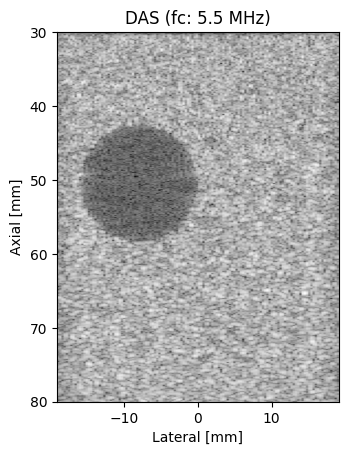

In [11]:
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[1], num=800)
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[1], num=128)
grid = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)
bmode_DAS, _ = make_bimg_das1(copy.deepcopy(P), grid, device='cpu')


extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
ax.imshow(bmode_DAS, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
ax.set_xlabel('Lateral [mm]')
ax.set_ylabel('Axial [mm]')
ax.set_title('DAS (fc: %.1f MHz)' % (P.fc/1e6))
plt.show()

## Computing metrics

In [12]:
from metrics import  compute_metrics

In [13]:
P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
contrast_img, cnr_img, snr_img, gcnr_img = compute_metrics(P.pos_lat,P.pos_ax,P.radius, bmode_DAS, grid)
print(contrast_img, cnr_img, snr_img, gcnr_img)

-16.882545948028564 -1.2732946 0.8629634239643112 1.4957354


# Metrics for testing set

## Params in testing set

In [28]:
import os
testing_folder = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\input_testing'
input_file_list = sorted(os.listdir(testing_folder))
print(input_file_list[-1][:-4])
int(input_file_list[-1][-9:-4])

simu12496


12496

In [24]:
import pandas as pd
import pickle
P = LoadDataParams(h5_dir=h5_dir, simu_name=f'simu00001')
with open("common_params.pkl", "wb") as f:
    pickle.dump(P, f)

In [31]:
r = []
cx = []
cz = []
c = []
ids = []
for file in input_file_list:
    P = LoadDataParams(h5_dir=h5_dir, simu_name=file[:-4])
    r.append(P.radius)
    c.append(P.c)
    cx.append(P.pos_lat)
    cz.append(P.pos_ax)
    ids.append(int(file[-9:-4]))
dataset_params = {"id": ids, "r": r, "cx": cx, "cz": cz, "c": c}
params_df = pd.DataFrame(dataset_params)
params_df.to_csv('dataset_params.csv')

In [32]:
params_df.head()

,id,r,cx,cz,c
0,14,0.008,-0.006,0.0550,1420.0
1,15,0.006,-0.008,0.0575,1570.0
2,16,0.006,-0.008,0.0475,1480.0
3,21,0.006,0.012,0.0600,1590.0
4,24,0.002,-0.004,0.0575,1420.0


## Computing images from model

In [36]:
from guided_diffusion import linear_beta_schedule, CustomDataset
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
input_folder = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\input_testing'
output_folder = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\target_testing'

In [42]:
data = CustomDataset(input_folder, output_folder, transform=True)
BATCH_SIZE = 4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
x_sample,y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
print(x_sample.shape)
data.input_file_list[:4]

torch.Size([4, 2, 800, 128])


['simu00014.npy', 'simu00015.npy', 'simu00016.npy', 'simu00021.npy']

In [ ]:
from model4 import UNETv10
from guided_diffusion import sample_image_cond

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))

In [ ]:
# NOISE SCHEDULE
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)


In [ ]:
y_gen, intermediate = sample_image_cond(x_sample, model, beta, num_intermediate=10)

In [ ]:
gen_folder = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\target_generated'
for sample in y_gen:
    print(sample.shape)
    break

In [8]:
# contrast_list = []
# for simu name
#     
#     P = getdata(simuname)
#     x,z,r = get_params(P)
#     
#     contrast, cnr, snr, gcnr = compute metrics(x,z,r, bmode)
#     
#     constrast_list.append(contrast)
#     
# df = pd.dataframe("x,z,c,r, contrast", columns=[constrast_list])

In [9]:
# import seaborn as sns

In [10]:
# sns.barplot(df=df, x='r', y='contrast')